# Example Using Pretrained VGG16

In [8]:
!pip install ttach

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from cv2 import cv2
import torch
import json
from torchvision import models, transforms
from grad_cam import GradCAM, GradCAMPlusPlus, show_cam_on_image
%matplotlib inline

# Image Preprocessing Methods

In [26]:
def load_images(image_paths, path_flag = 1):
    images = []
    raw_images = []
    print("Images:")
    for i, image_path in enumerate(image_paths):
        print("\t#{}: {}".format(i, image_path))
        raw_image = cv2.imread(image_path)
        image, raw_image = preprocess(raw_image)
        images.append(image)
        raw_images.append(raw_image)
    return images, raw_images

def preprocess(raw_image):
    try:
      raw_image = cv2.resize(raw_image, (255,) * 2)
    except Exception as e:
      print(str(e))
    
    img_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    image = img_transform(raw_image)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    return image, raw_image

# The Paths To The Image And Imagenet Class Index JSON File 

In [22]:
image_paths = ["image.jpg"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


In [24]:
# Opening JSON file
f = open("imagenet_class_index.json",)
class_idx = json.load(f)
labels = [class_idx[str(k)][1] for k in range(len(class_idx))]

# Using VGG16 And Predicting The Image Class
*I print the highest 5 classes*

In [27]:
model = models.vgg16(pretrained=True)
model = model.to(device)
print(model._modules.keys())
target_layer = model.features[-1]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

odict_keys(['features', 'avgpool', 'classifier'])


In [18]:
target_category = None
images, raw_images = load_images(['image.jpg'])
images = torch.stack(images).to(device)
rgb_img = raw_images[0].astype('float32')/np.max(raw_images[0])

Images:
	#0: image.jpg


In [28]:
model.eval()
with torch.no_grad():
    outputs = model(images[0].unsqueeze(0))

# Print predictions
print('-----')
for idx in torch.topk(outputs, k=5).indices.squeeze(0).tolist():
    prob = torch.softmax(outputs, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[idx], p=prob*100))
    print(idx)

-----
bulbul                                                                      (22.03%)
16
orange                                                                      (6.99%)
950
robin                                                                       (6.36%)
15
partridge                                                                   (5.92%)
86
quail                                                                       (5.06%)
85


# Grad-CAM Visualization

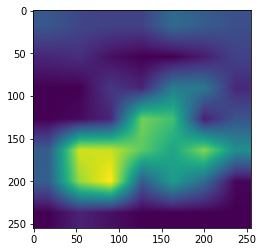

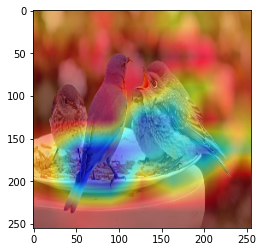

In [31]:
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=images, target_category=target_category)
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
plt.imshow(grayscale_cam)
plt.show()
visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_cam)
plt.imshow(visualization)
plt.show()

# Grad-CAM++ Visualization

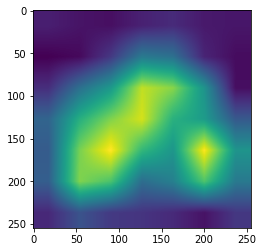

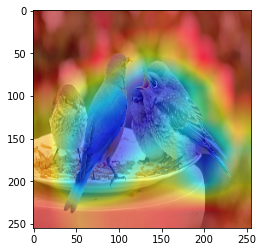

In [32]:
cam = GradCAMPlusPlus(model=model, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=images, target_category=target_category)
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
plt.imshow(grayscale_cam)
plt.show()
visualization = show_cam_on_image(rgb_img.astype('float32'), grayscale_cam)
plt.imshow(visualization)
plt.show()